# Задание, оцениваемое сокурсниками:
# Анализ данных в задаче кредитного скоринга (scoring)

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from statsmodels.stats.weightstats import zconfint
from scipy import stats

np.set_printoptions(suppress=True)

%matplotlib inline

In [2]:
data = pd.read_csv("credit_card_default_analysis.csv")
data.drop("ID", axis=1, inplace=True)

# Разбиение LIMIT_BAL на категории
lbr = np.arange(0, 11e5 + 1, 1e5).astype(int)
lb = map(lambda x: "{}<".format(x, x + 1e5 - 1), lbr[:-1])
lb = dict(zip(range(len(lb)), lb))
data["LIMIT_BAL_CAT"] = pd.cut(data.LIMIT_BAL, lbr, right=False, labels=range(len(lb)))

# Разбиение AGE на категории
acr = np.arange(20, 81, 5)
ac = map(lambda x: "{}..{}".format(x, x + 4), acr[:-1])
ac = dict(zip(range(len(ac)), ac))
data["AGE_CAT"] = pd.cut(data.AGE, acr, right=False, labels=range(len(ac)))

# С этим буду работать
def0 = data[data.default == 0]
def1 = data[data.default == 1]

print data.shape, def0.shape, def1.shape
data.head()

(30000, 26) (23364, 26) (6636, 26)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,LIMIT_BAL_CAT,AGE_CAT
0,20000,2,2,1,24,2,2,0,0,0,...,0,0,689,0,0,0,0,1,0,0
1,120000,2,2,2,26,0,2,0,0,0,...,3261,0,1000,1000,1000,0,2000,1,1,1
2,90000,2,2,2,34,0,0,0,0,0,...,15549,1518,1500,1000,1000,1000,5000,0,0,2
3,50000,2,2,1,37,0,0,0,0,0,...,29547,2000,2019,1200,1100,1069,1000,0,0,3
4,50000,1,2,1,57,0,0,0,0,0,...,19131,2000,36681,10000,9000,689,679,0,0,7


In [3]:
df = {
    0: u"вернул",
    1: u"не вернул"
}

sx = {
    1: u"мужской",
    2: u"женский"
}

ed = {
    0: u"доктор",
    1: u"магистр",
    2: u"бакалавр",
    3: u"выпускник школы",
    4: u"начальное образование",
    5: u"прочее",
    6: u"нет данных"
}

mr = {
    0: u"отказываюсь отвечать",
    1: u"замужем/женат",
    2: u"холост",
    3: u"нет данных"
}

In [4]:
def proportions(feature_name, feature_values=None, cmap="rainbow"):
    # Таблица
    vc0 = def0[feature_name].value_counts()
    vc1 = def1[feature_name].value_counts()

    vc = pd.concat([vc0, vc1], axis=1).fillna(0)
    vc = pd.concat([vc, vc0/vc1], axis=1)

    vc.columns = df.values() + ["proportion"] 
    if feature_values:
        vc.index = feature_values.values()

    # График
    plt.figure(figsize=(16, 8))
    r = np.random.randn(2, len(data)) / 8

    x = data[feature_name] + r[0]
    y = data.default + r[1]
    plt.scatter(x, y, s=5, c=data[feature_name], cmap=cmap)

    if feature_values:
        plt.xticks(feature_values.keys(), feature_values.values())
    plt.yticks(df.keys(), df.values())
    plt.grid(True)
    plt.show()

#    vc[df.values()].plot.bar(color="gr", figsize=(16, 4))
    vc.proportion.plot.bar(figsize=(16, 4))
    plt.show()
    
    print u"Чем больше 'proportion', тем приятнее банку работать с группой :)"
    return vc.sort_values("proportion", na_position="first", ascending=False)

In [5]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [6]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative="two-sided"):
    if alternative not in ("two-sided", "less", "greater"):
        raise ValueError("alternative not recognized\nshould be 'two-sided', 'less' or 'greater'")
    
    if alternative == "two-sided":
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))   

    if alternative == "less":
        return scipy.stats.norm.cdf(z_stat)

    if alternative == "greater":
        return 1 - scipy.stats.norm.cdf(z_stat)

# 1
---
Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

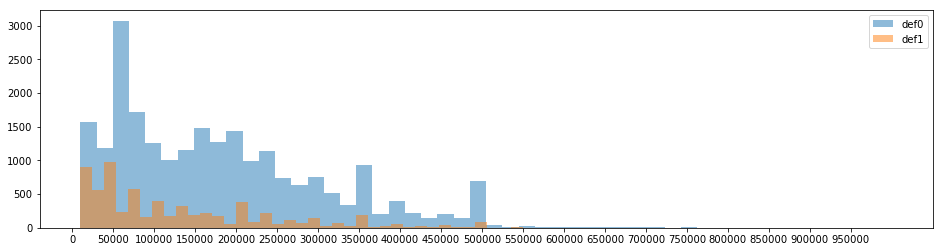

In [7]:
plt.figure(figsize=(16, 4))
plt.hist(def0.LIMIT_BAL, bins=50, alpha=0.5, label="def0")
plt.hist(def1.LIMIT_BAL, bins=50, alpha=0.5, label="def1")
plt.xticks(np.arange(0, 1e6, 5e4))
plt.legend()

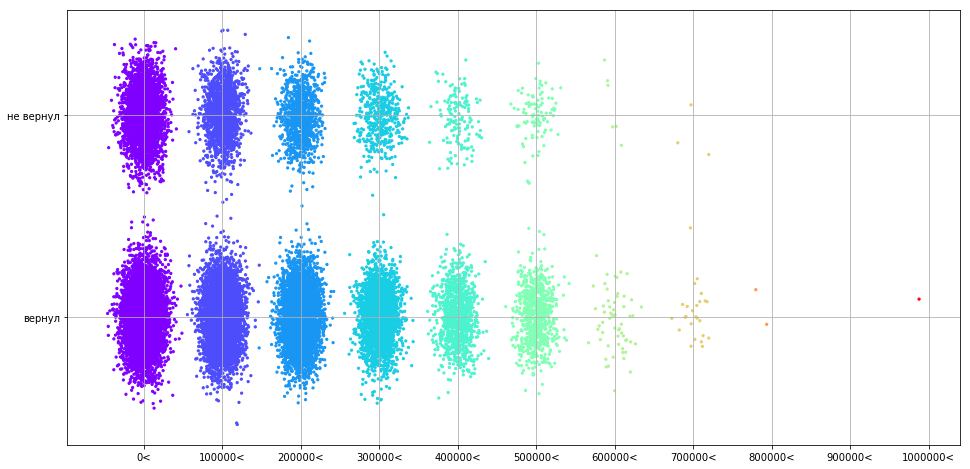

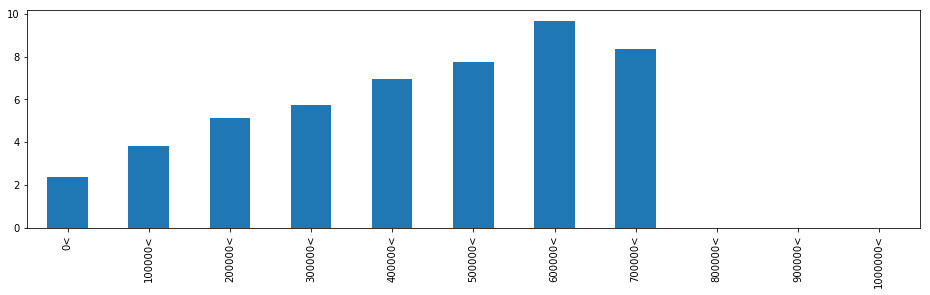

Чем больше 'proportion', тем приятнее банку работать с группой :)


,вернул,не вернул,proportion
900000<,0,0,NaN
800000<,2,0,inf
1000000<,1,0,inf
600000<,58,6,9.666667
700000<,25,3,8.333333
500000<,738,95,7.768421
400000<,1003,144,6.965278
300000<,2590,452,5.730088
200000<,5046,987,5.112462
100000<,5863,1537,3.814574


In [8]:
proportions("LIMIT_BAL_CAT", lb)

$H_0\colon$ интервалы пересекаются

$H_1\colon$ интервалы не пересекаются

In [9]:
np.random.seed(0)
def0_m = np.median(get_bootstrap_samples(def0.LIMIT_BAL.values, 1000), axis=1)
def1_m = np.median(get_bootstrap_samples(def1.LIMIT_BAL.values, 1000), axis=1)

# median
print stat_intervals(def0_m)
print stat_intervals(def1_m)

# mean
print np.round(zconfint(def0.LIMIT_BAL), 4)
print np.round(zconfint(def1.LIMIT_BAL), 4)

[ 150000.  150000.]
[ 80000.  90000.]
[ 176411.9145  179787.5377]
[ 127333.6533  132885.6595]


$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [10]:
mw = stats.mannwhitneyu(def0.LIMIT_BAL, def1.LIMIT_BAL, alternative="two-sided")
print mw[1], mw[1] > 0.05

1.22554858182e-189 False


**Ответ:**

1.a) $H_0$ отвергается

1.b) $H_0$ отвергается

Большие суммы возвращают охотнее о_О

# 2
---
Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия) 

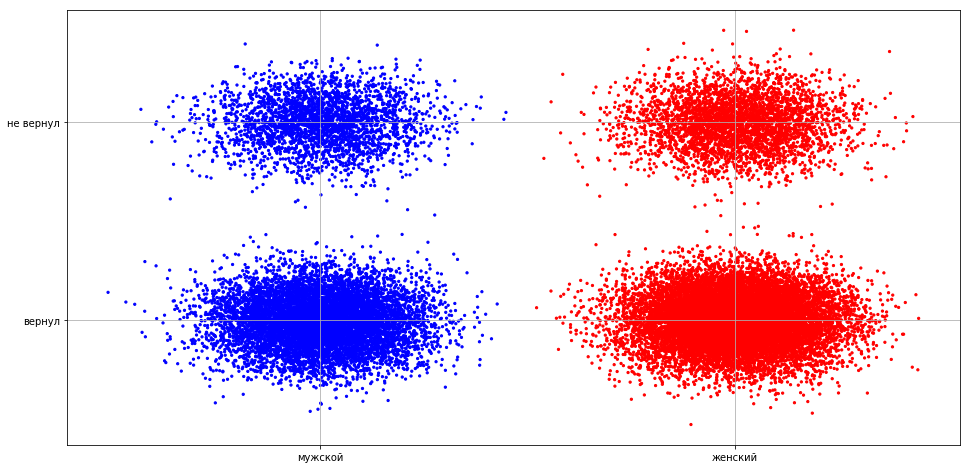

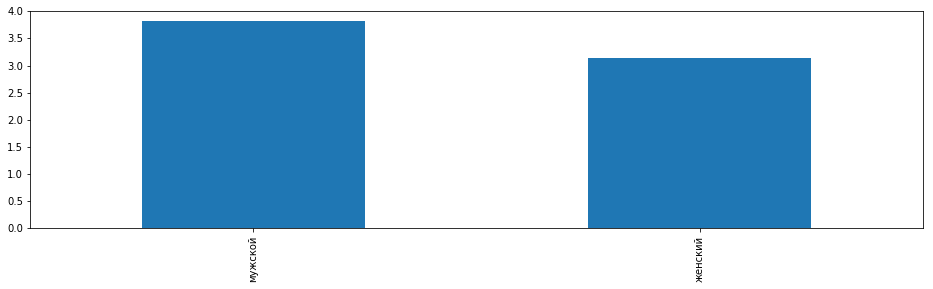

Чем больше 'proportion', тем приятнее банку работать с группой :)


,вернул,не вернул,proportion
мужской,14349,3763,3.813181
женский,9015,2873,3.137835


In [11]:
proportions("SEX", sx, cmap=ListedColormap(["blue", "red"]))

$H_0\colon$ гендерный состав групп различается

$H_1\colon$ гендерный состав групп не различается

In [12]:
mw = stats.mannwhitneyu(def0.SEX, def1.SEX, alternative="two-sided")
print mw[1], mw[1] > 0.05

4.47647869213e-12 False


In [13]:
res = proportions_confint_diff_ind(def0.SEX.values - 1, def1.SEX.values - 1)
print np.round(res, 4), res[0] <= 0 <= res[1]

[ 0.0336  0.0605] False


In [14]:
res = proportions_diff_z_test(proportions_diff_z_stat_ind(def0.SEX.values - 1, def1.SEX.values - 1))
print res, res > 0.05

4.47286652161e-12 False


**Ответ:**

2) $H_0$ отвергается

# 3
---
Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ? 

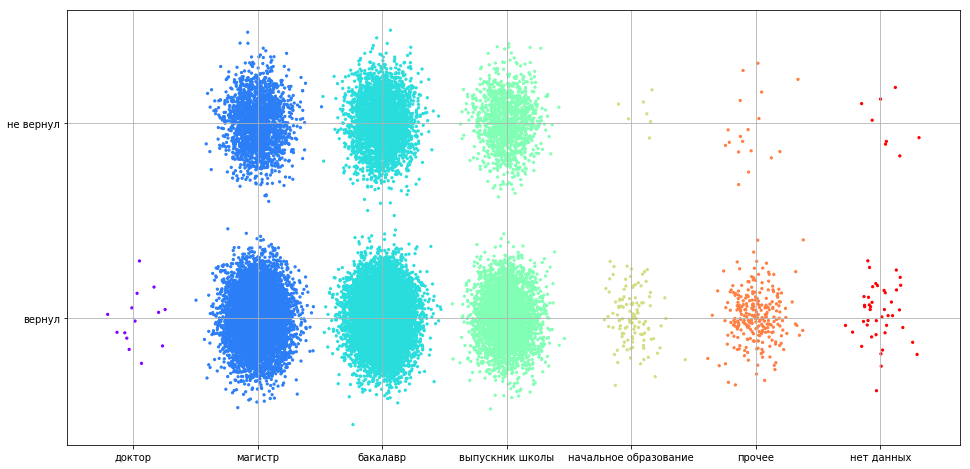

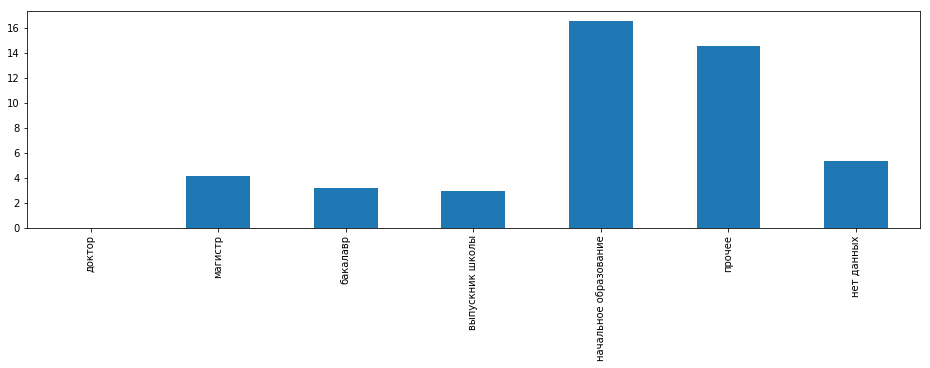

Чем больше 'proportion', тем приятнее банку работать с группой :)


,вернул,не вернул,proportion
доктор,14,0.0,NaN
начальное образование,116,7.0,16.571429
прочее,262,18.0,14.555556
нет данных,43,8.0,5.375000
магистр,8549,2036.0,4.198919
бакалавр,10700,3330.0,3.213213
выпускник школы,3680,1237.0,2.974939


In [15]:
vc = proportions("EDUCATION", ed)
teducation = vc.iloc[:, :-1].values
vc

$H_0\colon$ образование не влияет на возврат долга

$H_1\colon$ образование влияет на возврат долга

In [16]:
mw = stats.mannwhitneyu(def0.EDUCATION, def1.EDUCATION, alternative="two-sided")
print mw[1], mw[1] > 0.05

1.53235181893e-14 False


In [17]:
res = stats.chi2_contingency(teducation)
print res[1], res[1] > 0.05

1.23326262454e-32 False


**Ответ:**

3) $H_0$ отвергается

Докторам - давать, выпускникам школы - не давать

# 4
---
Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

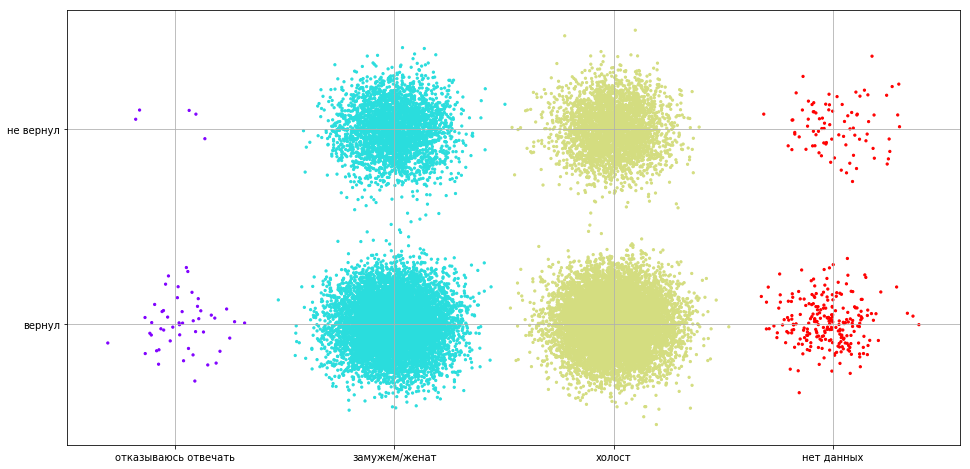

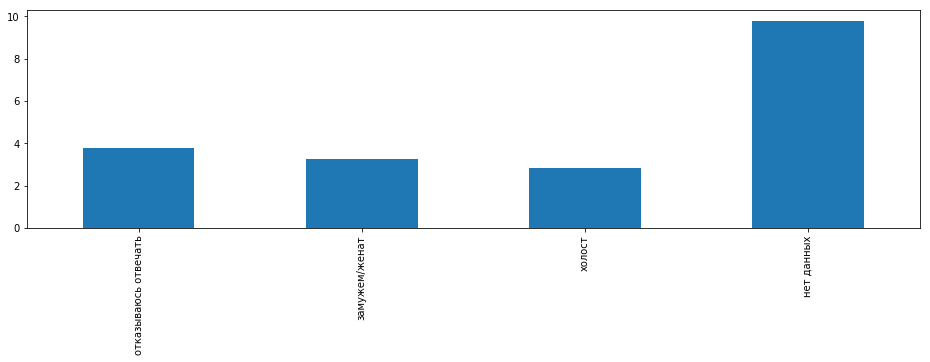

Чем больше 'proportion', тем приятнее банку работать с группой :)


,вернул,не вернул,proportion
нет данных,49,5,9.800000
отказываюсь отвечать,12623,3341,3.778210
замужем/женат,10453,3206,3.260449
холост,239,84,2.845238


In [18]:
vc = proportions("MARRIAGE", mr)
tmarriage = vc.iloc[:, :-1].values
vc

$H_0\colon$ семейное положение не влияет на возврат долга

$H_1\colon$ семейное положение влияет на возврат долга

In [19]:
mw = stats.mannwhitneyu(def0.MARRIAGE, def1.MARRIAGE, alternative="two-sided")
print mw[1], mw[1] > 0.05

4.47322335247e-06 False


In [20]:
res = stats.chi2_contingency(tmarriage)
print "Cramer: %.4f" % (res[0] / tmarriage.sum(axis=0).sum()) ** 0.5
print res[1], res[1] > 0.05

Cramer: 0.0345
8.82586245758e-08 False


**Ответ:**

4) $H_0$ отвергается

# 5
---
Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

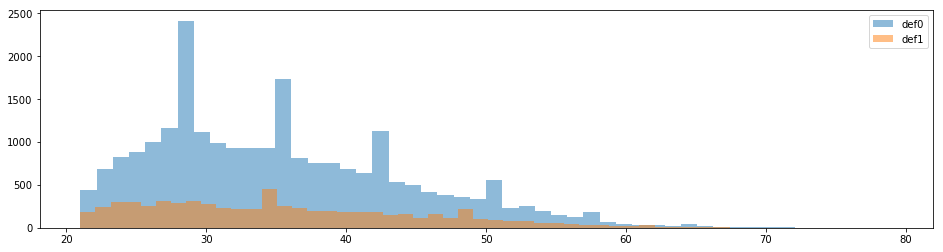

In [21]:
plt.figure(figsize=(16, 4))
plt.hist(def0.AGE, bins=50, alpha=0.5, label="def0")
plt.hist(def1.AGE, bins=50, alpha=0.5, label="def1")
plt.legend()

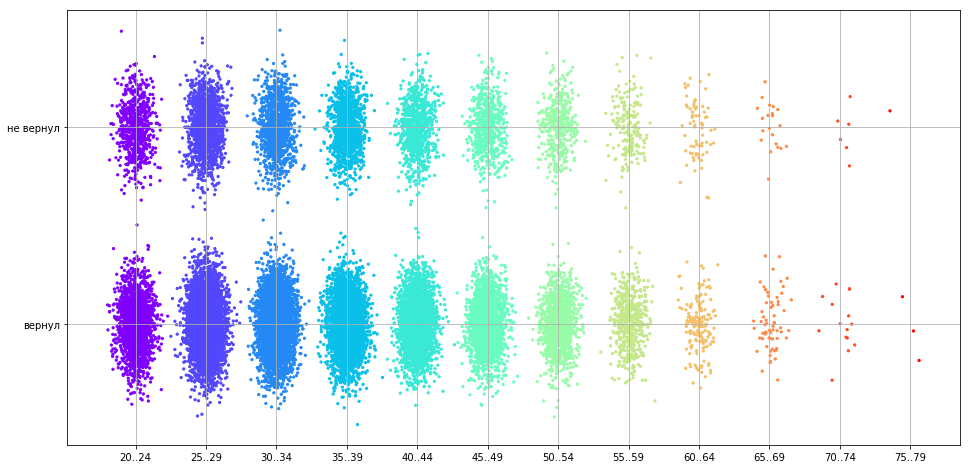

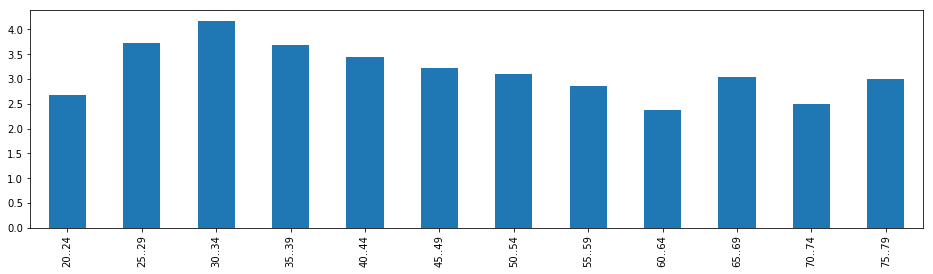

Чем больше 'proportion', тем приятнее банку работать с группой :)


,вернул,не вернул,proportion
30..34,4904,1174,4.177172
25..29,5466,1467,3.725971
35..39,4058,1102,3.682396
40..44,2989,869,3.439586
45..49,1990,616,3.230519
50..54,1230,397,3.098237
65..69,64,21,3.047619
75..79,3,1,3.000000
55..59,529,185,2.859459
20..24,1955,730,2.678082


In [22]:
proportions("AGE_CAT", ac)

$H_0\colon$ интервалы пересекаются

$H_1\colon$ интервалы не пересекаются

In [23]:
np.random.seed(0)
def0_m = np.median(get_bootstrap_samples(def0.AGE.values, 1000), axis=1)
def1_m = np.median(get_bootstrap_samples(def1.AGE.values, 1000), axis=1)

# median
print stat_intervals(def0_m)
print stat_intervals(def1_m)

# mean
print np.round(zconfint(def0.AGE), 4)
print np.round(zconfint(def1.AGE), 4)

[ 34.  34.]
[ 34.  35.]
[ 35.3009  35.5337]
[ 35.4925  35.959 ]


$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [24]:
mw = stats.mannwhitneyu(def0.AGE, def1.AGE, alternative="two-sided")
print mw[1], mw[1] > 0.05

0.37250354349 True


**Ответ:**

5.a) $H_0$ принимается

5.b) $H_0$ принимается

В любом возрасте есть люди, предпочитающие не возращать деньги, но (25-35)-летние более ответственны в этом вопросе